# Data Visualization
## Objectives
* Answer business the requirement 1:
    * Average images and variability images for each class (healthy or powdery mildew).
    * The differences between average healthy and average powdery mildew cherry leaves.
    * An image montage for each class.
## Inputs
* inputs/cherry-leaves/train
* inputs/cherry-leaves/validation
* inputs/cherry-leaves/test
## Outputs
* Average images and variability images for each class (healthy or powdery mildew).
* An image showing the differences between average healthy and average powdery mildew cherry leaves.
* An image montage for each class.
## Import packages

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import itertools
import random
from matplotlib.image import imread
from tensorflow.keras.preprocessing import image

## Set plot style

In [3]:

sns.set_style("white")

## Change the working directory

In [4]:
os.chdir('/workspace/Project_five')
current_directory = os.getcwd()
print(f"Your current directory is '{current_directory}'")

Your current directory is '/workspace/Project_five'


## Set input directories

In [5]:
getdirectory = os.getcwd()
directory = 'inputs/cherry-leaves'
train_path = directory + '/train'
val_path = directory + '/validation'
test_path = directory + '/test'

## Create outputs folder

In [6]:

if 'outputs' not in os.listdir(os.getcwd()):
    os.makedirs(name="outputs")
    print("outputs folder created")
else:
    print("outputs folder is ready")


outputs folder is ready


## Set output directory

In [7]:
# To make a new set of outputs change the version variable
version = 'v1'
file_path = f'outputs/{version}'
if version not in os.listdir("outputs"):
  os.makedirs(name=file_path)
else:
    print('Version ready')

Version ready


## Checking image sizes

In [26]:
dim1 = []
dim2 = []
folder_to_calculate = os.listdir(train_path)
for folder in folder_to_calculate:
  for image_filename in os.listdir(train_path + '/'+ folder):
    img = imread(train_path + '/' + folder + '/'+ image_filename)
    d1, d2, colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

def unique(dim):
    x = np.array(dim)
    y = np.unique(x)
    print(f"Unique values: {y}")
    return y

dim1_unique = unique(dim1)
dim2_unique = unique(dim2)

print(f"dim1 has {len(dim1_unique)} unique values\ndim2 has {len(dim1_unique)} unique values")

Unique values: [256]
Unique values: [256]
dim1 has 1 unique values
dim2 has 1 unique values


* As we can see all the image shapes are identical
* We can set this as a varable

In [27]:
images_shape = (dim1_unique[0], dim1_unique[0], 3)
images_shape

(256, 256, 3)

## Loading images in an array

In [38]:
# This function is from the Code Institutes walkthrough project
def load_image_as_array(my_data_dir, new_size=(50,50), n_images_per_label = 30):
  
  # X and y store the values of the images and there labels
  X, y = np.array([], dtype='int'), np.array([], dtype='object')
  labels = os.listdir(my_data_dir)

  for label in labels:
    # we count 30 images as seen in n_images_per_label because adding them all would take too long
    counter = 0
    for image_filename in os.listdir(my_data_dir + '/' + label):
      if counter < n_images_per_label:
        
        img = image.load_img(my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
        if image.img_to_array(img).max() > 1: 
          img_resized = image.img_to_array(img) / 255
        else: 
          img_resized = image.img_to_array(img)
        
        X = np.append(X, img_resized).reshape(-1, new_size[0], new_size[1], img_resized.shape[2])
        y = np.append(y, label)
        counter += 1

  return X, y

X, y = load_image_as_array(my_data_dir=train_path,new_size=images_shape,n_images_per_label = 30)
print(X.shape, y.shape)

(60, 256, 256, 3) (60,)


## Plot and save mean and variability of images per label

==== Label healthy ====
Image Shape: (256, 256, 3)
==== Label powdery_mildew ====
Image Shape: (256, 256, 3)


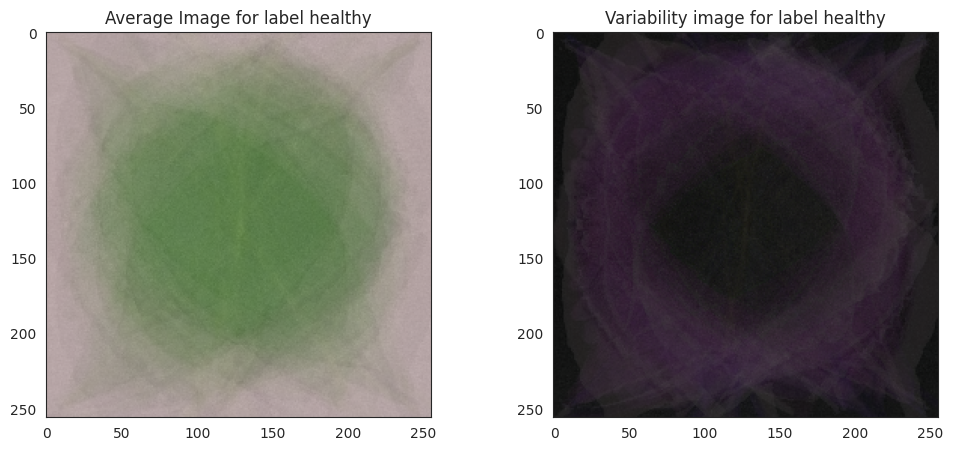

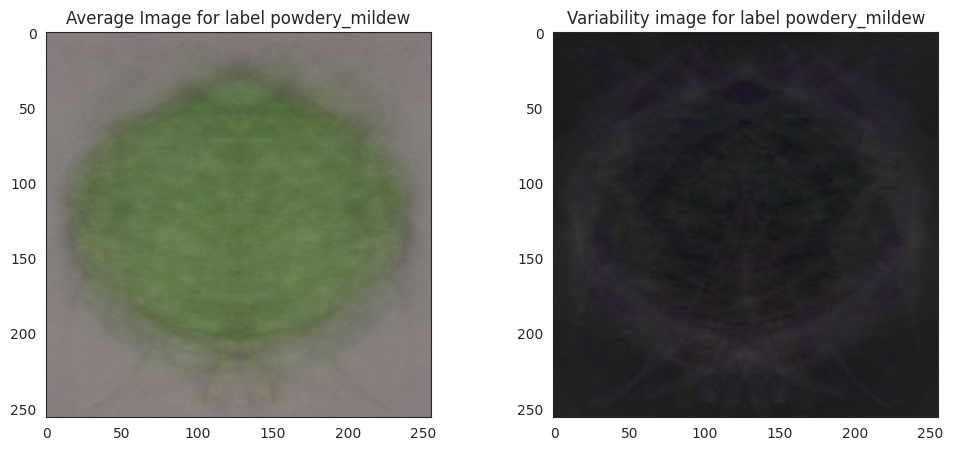

In [40]:
# This function is from the Code Institutes walkthrough project
def plot_mean_variability_per_labels(X, y, figsize=(12,5), save_image=False):
  for label_to_display in np.unique(y):
    y = y.reshape(-1,1,1)
    # A boolean_mask allows us to place one array on top of the other and only take the values that are matched with the label_to_display
    boolean_mask = np.any(y==label_to_display,axis=1).reshape(-1)
    arr = X[boolean_mask]

    # we caculate the average using mean
    avg_img = np.mean(arr, axis = 0)
    # we caculate the variability using standard deviation
    std_img = np.std(arr, axis = 0)
    print(f"==== Label {label_to_display} ====")
    print(f"Image Shape: {avg_img.shape}")
    # Then we plot them both
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    axes[0].set_title(f"Average Image for label {label_to_display}")
    axes[0].imshow(avg_img, cmap='gray')
    axes[1].set_title(f"Variability image for label {label_to_display}")
    axes[1].imshow(std_img, cmap='gray')

    if save_image:
      # We save the images to our output folder
      plt.savefig(f"{file_path}/avg_var_{label_to_display}.png", bbox_inches='tight', dpi=150)
    else:
      plt.tight_layout()
      plt.show()
      print("\n")

plot_mean_variability_per_labels(X=X, y=y, figsize=(12,5),save_image=True)

## Difference between average powdery mildew and average healthy images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


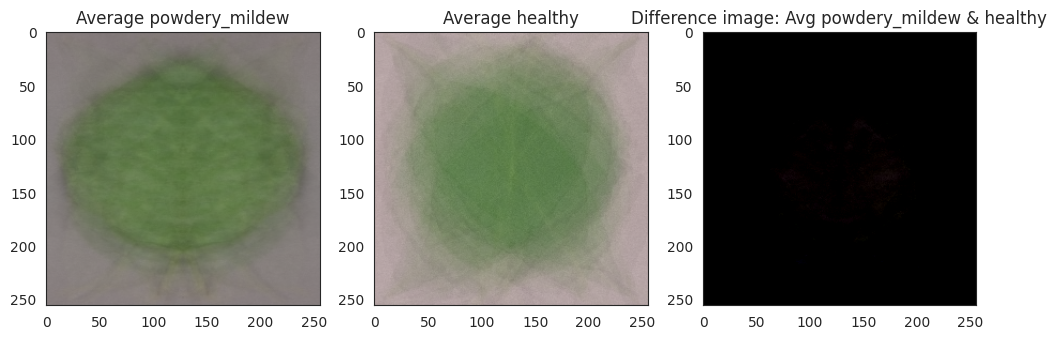

In [41]:
# This function is from the Code Institutes walkthrough project
def subset_image_label(X,y,label_to_display):
  y = y.reshape(-1,1,1)
  # We use the boolean_mask again to get the values acording to label_to_display
  boolean_mask = np.any(y==label_to_display,axis=1).reshape(-1)
  df = X[boolean_mask]
  return df


def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20,5), save_image=False):
  # This checks to make sure we called the function with a correct labels
  if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
    print(f"Either label {label} or label {label_2}, are not in {np.unique(y)} ")
    return

  # calculate mean from label1 using np.mean
  images_label = subset_image_label(X, y, label_1)
  label1_avg = np.mean(images_label, axis = 0)

  # calculate mean from label2 using np.mean
  images_label = subset_image_label(X, y, label_2)
  label2_avg = np.mean(images_label, axis = 0)

  # calculate difference and plot difference, avg label1 and avg label2
  difference_mean = label1_avg - label2_avg
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
  axes[0].imshow(label1_avg, cmap='gray')
  axes[0].set_title(f'Average {label_1}')
  axes[1].imshow(label2_avg, cmap='gray')
  axes[1].set_title(f'Average {label_2}')
  axes[2].imshow(difference_mean, cmap='gray')
  axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
  if save_image:
    # save the plots
    plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
  else:
    plt.tight_layout()
    plt.show()

diff_bet_avg_image_labels_data_as_array(X=X, y=y,label_1='powdery_mildew', label_2='healthy',figsize=(12,10),save_image=True)

healthy


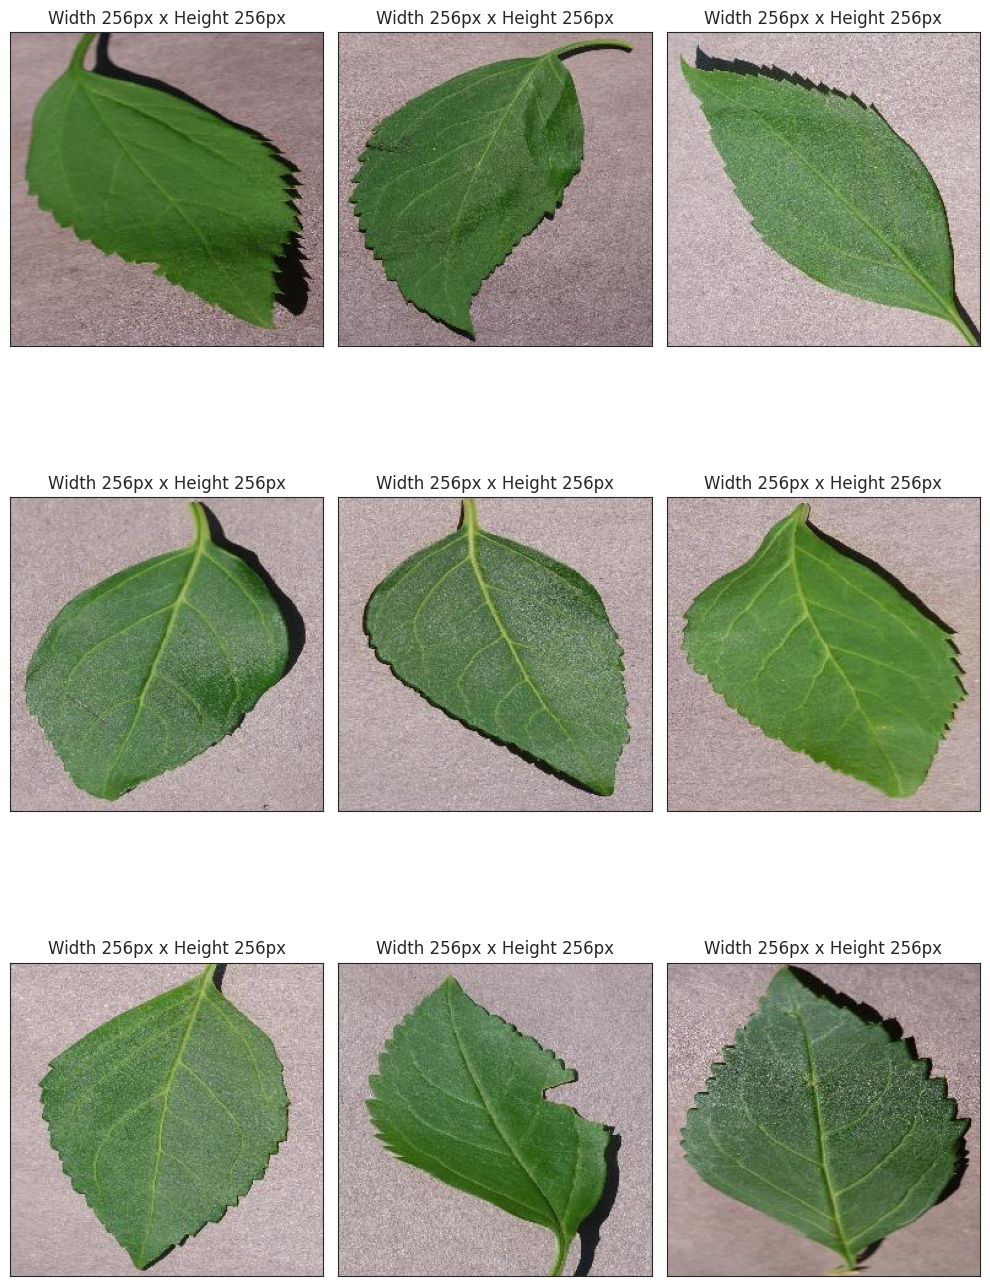



powdery_mildew


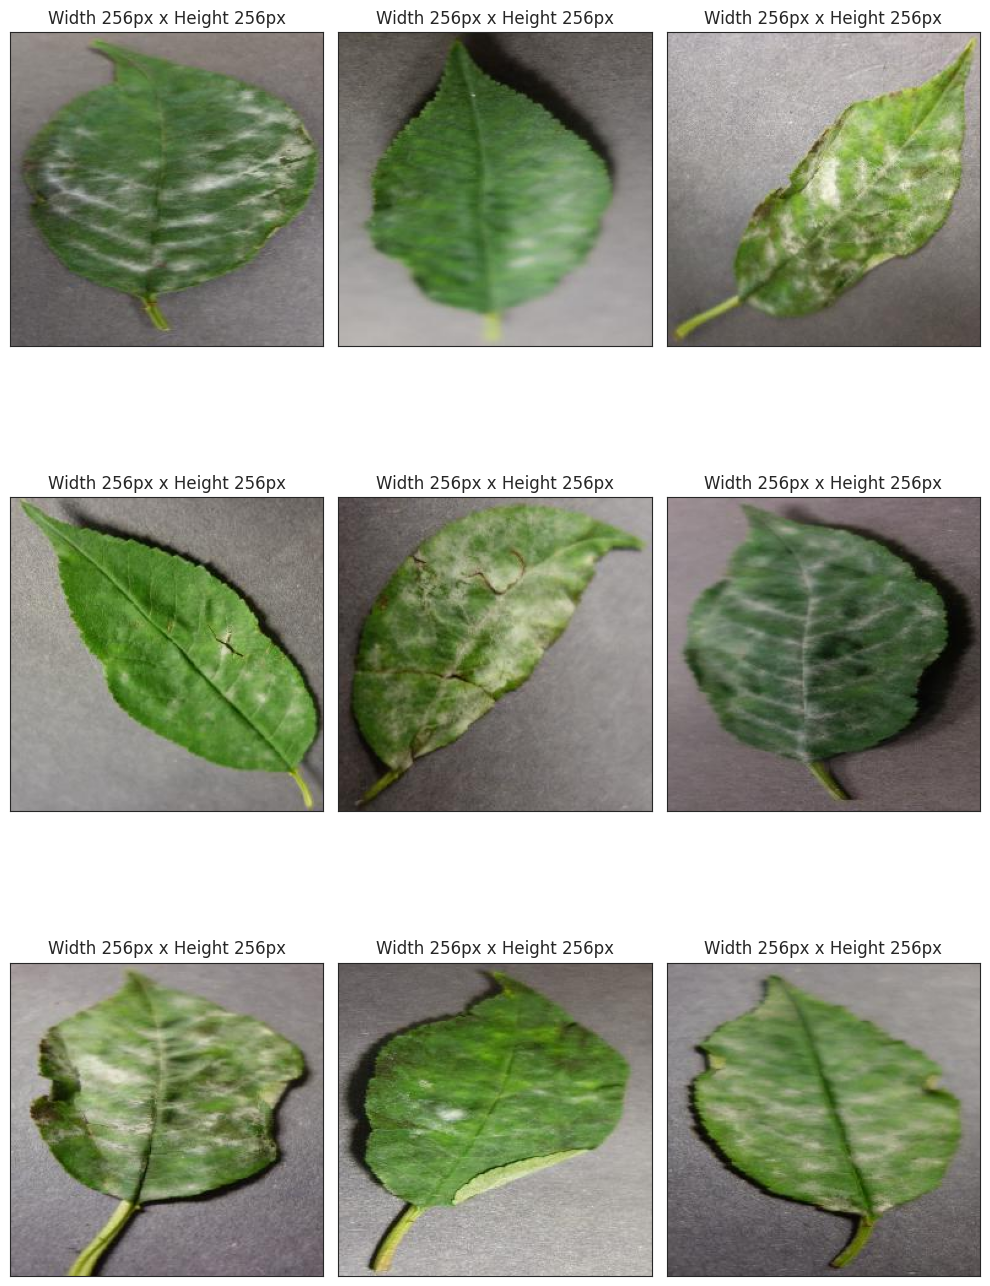

In [85]:
# This function is from the Code Institutes walkthrough project
def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15,10)):
  

  labels = os.listdir(dir_path)

  # subset the class you are interested to display
  if label_to_display in labels:

    # checks if your montage space is greater than subset size
    images_list = os.listdir(dir_path+'/'+ label_to_display)
    if nrows * ncols < len(images_list):
      img_idx = random.sample(images_list, nrows * ncols)
    else:
      print(
          f"Decrease nrows or ncols to create your montage. \n"
          f"There are {len(images_list)} in your subset. "
          f"You requested a montage with {nrows * ncols} spaces")
      return
    

    # create list of axes indices based on nrows and ncols
    list_rows= range(0,nrows)
    list_cols= range(0,ncols)
    plot_idx = list(itertools.product(list_rows,list_cols))


    # create a Figure and display images
    fig, axes = plt.subplots(nrows=nrows,ncols=ncols, figsize=figsize)
    for x in range(0,nrows*ncols):
      img = imread(dir_path + '/' + label_to_display + '/' + img_idx[x])
      img_shape = img.shape
      axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
      axes[plot_idx[x][0], plot_idx[x][1]].set_title(f"Width {img_shape[1]}px x Height {img_shape[0]}px")
      axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
      axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
    plt.tight_layout()
    plt.show()


  else:
    print("The label you selected doesn't exist.")
    print(f"The existing options are: {labels}")

for label in labels:
  print(label)
  image_montage(dir_path= train_path,label_to_display= label,nrows=3, ncols=3,figsize=(10,15))
  print("\n")

## Outputs
* Average images and variability images for each class (healthy or powdery mildew).
* An image showing the differences between average healthy and average powdery mildew cherry leaves.
* An image montage for each class.